# Определение перспективного тарифа для телеком-компании

## О проекте

### Цель

Мобильному оператору необходимо скорректировать рекламный бюджет, для определения доходности тарифных планов.<br>
Для реализации задания необходимо провести предварительный анализ тарифов по выборке для 500 пользователей. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


### План

1. Открытие файлов с данными и изучение общей информации
2. Подготовка данных:
- Приведение данные к нужным типам;
- Поиск и исправление ошибок;
- Подсчёт для каждого пользователя количества сделанных звонков и израсходованных минут по месяцам, количества отправленных сообщений по месяцам, объема израсходованного интернет-трафика по месяцам, помесячную выручку с каждого пользователя.
3. Анализ данных (сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц; среднее количество, дисперсия и стандартное отклонение; описание распределения).
4. Проверка гипотез (средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов)
5. Написание общего вывода

### Сведения о данных

Таблица users:
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана
Таблица calls:
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок
Таблица messages:
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение
Таблица internet:
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя
Таблица tariffs:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Знакомство с данными

### Просмотр информации из таблиц и о таблицах

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import math
from scipy import stats as st

*После иморта библиотек, пооберёдно открываю каждый файл, прослатриваю информацию о таблице а также данные, содержащиеся в ней*

In [2]:
# Прсмотр таблицы с информацией о звонках
calls=pd.read_csv('/datasets/calls.csv', sep=',')
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [3]:
calls.info() #оценка общей информации о таблице звонков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
# Прсмотр таблицы с информацией об интернет-сессиях
internet=pd.read_csv('/datasets/internet.csv', sep=',')
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [5]:
internet.info() #оценка общей информации о таблице интернет-сессий

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
# Прсмотр таблицы с информацией о сообщениях
messages=pd.read_csv('/datasets/messages.csv', sep=',')
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [7]:
messages.info() #оценка общей информации о таблице сообщений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [8]:
# Прсмотр таблицы с информацией о тарифах
tariffs=pd.read_csv('/datasets/tariffs.csv', sep=',')
tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
tariffs.info() #оценка общей информации о таблице тарифов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [10]:
# Прсмотр таблицы с информацией о пользователях
users=pd.read_csv('/datasets/users.csv', sep=',')
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [11]:
users.info() #оценка общей информации о таблице пользователей

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Поиск пропусков и дубликатов в каждой таблице

In [12]:
# Поиск пропусков
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [13]:
#Проверка присутствия дубликатов
display(calls.duplicated().sum())

0

In [14]:
# Поиск пропусков
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [15]:
#Проверка присутствия дубликатов
display(internet.duplicated().sum())

0

In [16]:
# Поиск пропусков
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [17]:
#Проверка присутствия дубликатов
display(messages.duplicated().sum())

0

In [18]:
# Поиск пропусков
tariffs.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

In [19]:
#Проверка присутствия дубликатов
display(tariffs.duplicated().sum())

0

In [20]:
# Поиск пропусков
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [21]:
#Проверка присутствия дубликатов
display(users.duplicated().sum())

0

### Исправление ошибок

In [22]:
# Перевела секунды в минуты и округлила их согласно примечанию к заданию: секунды округляются до минут
# Столбец, содержащий округлённые в большую сторону минуты разговора, перевела в int
calls['duration_min']=(calls['duration']).apply(np.ceil).astype(int) 
calls.head()

,id,call_date,duration,user_id,duration_min
0,1000_0,2018-07-25,0.00,1000,0
1,1000_1,2018-08-17,0.00,1000,0
2,1000_2,2018-06-11,2.85,1000,3
3,1000_3,2018-09-21,13.80,1000,14
4,1000_4,2018-12-15,5.18,1000,6


In [23]:
#Изменение названия столбца для избежания путаницы в последующем анализе
messages=messages.rename(columns={'id':'mess'})
messages.head()

,mess,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


### Выводы

После оценки информации о данных можно сделать следующие выводы:
- В таблицах представлены данные о ползователях, их тарифных платах, сообщениях, интернет-сессиях и звонках.
- Пропуки обнаружены только в таблице со сведениями о пользователях. Однако в пояснении к заданию указно, что пропущенные знаения обозначают то, что тариф ещё действовал на момент выгрузки данных.
- Явных дубликатов не выявлено.
- Ошибок в названиях колонок не нашла.
- Из замечаний: я округлила секунды до минут в таблице calls поскольку в поянении к заданию значится, что "«Мегалайн» всегда округляет секунды до минут".

## Предварительные подсчёты

### Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя

Проведу подсчёты, по звонкам, после чего объеденю таблицы  `calls` и `users`. Объединение необходимо так как размещены сведения длительности звонков и наличия того или иного тарифа у абонента.

*Так как оценку необходимо проводить по месяцам, создам отдельный столбец с данными о номерах меяцев*

In [24]:
calls['month']=pd.to_datetime(calls['call_date']).astype('datetime64[M]').dt.month
calls.head(10)

,id,call_date,duration,user_id,duration_min,month
0,1000_0,2018-07-25,0.00,1000,0,7
1,1000_1,2018-08-17,0.00,1000,0,8
2,1000_2,2018-06-11,2.85,1000,3,6
3,1000_3,2018-09-21,13.80,1000,14,9
4,1000_4,2018-12-15,5.18,1000,6,12
5,1000_5,2018-11-02,0.00,1000,0,11
6,1000_6,2018-10-18,0.00,1000,0,10
7,1000_7,2018-08-22,18.31,1000,19,8
8,1000_8,2018-09-15,18.44,1000,19,9
9,1000_9,2018-08-15,0.00,1000,0,8


*Подсчёт использованных минут и количества звонков для каждого пользователя по месяцам выполню с помощью `pivot_table`*

In [25]:
calls_month=calls.pivot_table(index=['user_id','month'], values='duration_min', aggfunc=('count','sum')).reset_index()
calls_month.head()

,user_id,month,count,sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [26]:
# Объединяю полученную таблицу с данными по звонкам и клиентам
calls_users=users.merge(calls_month, on='user_id', how='left').reset_index()
calls_users.head()

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,count,sum
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0


In [27]:
#После объединения таблиц предположительно образовались пропуски данных
calls_users.isna().sum()

index            0
user_id          0
age              0
churn_date    2993
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
month            8
count            8
sum              8
dtype: int64

In [28]:
# Так как пропусков немного (всего 8), я удалю строки, содержащие их
calls_users=calls_users.dropna(subset=['month'])

In [29]:
calls_users.isna().sum()

index            0
user_id          0
age              0
churn_date    2987
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
month            0
count            0
sum              0
dtype: int64

In [30]:
calls_users.head()

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,count,sum
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0


In [31]:
calls_users=calls_users.rename(columns={'count':'count_calls', 'sum':'sum_calls'})
calls_users.head()

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,count_calls,sum_calls
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0


### Количество отправленных сообщений по месяцам

Здесь, как и впрошлом пункте, объеденю талицу по пользоваьтелям и сообщениям. Далее, измень формат месяца и посчитаю количество сообщений.

In [32]:
# Объединение таблицы с данными о пользователях и сообщениях
messages_users=users.merge(messages, on='user_id', how='left').reset_index()
messages_users.head(10)

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,mess,message_date
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05
5,5,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_5,2018-06-20
6,6,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_6,2018-11-19
7,7,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_7,2018-10-29
8,8,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_8,2018-06-25
9,9,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_9,2018-12-18


In [33]:
#После объединения таблиц предположительно образовались пропуски данных
messages_users.isna().sum()

index                0
user_id              0
age                  0
churn_date      117762
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
mess                74
message_date        74
dtype: int64

In [34]:
# Удалю строки, содержащие пропуски, поскольку подмтановка значений может изменить результат анализа
messages_users=messages_users.dropna(subset=['mess'])
messages_users.isna().sum()

index                0
user_id              0
age                  0
churn_date      117697
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
mess                 0
message_date         0
dtype: int64

In [35]:
# Создание столбца с номером месяца
messages_users['month']=pd.to_datetime(messages_users['message_date']).astype('datetime64[M]').dt.month
messages_users.head(10)

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,mess,message_date,month
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27,6
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08,10
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04,8
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16,6
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05,12
5,5,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_5,2018-06-20,6
6,6,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_6,2018-11-19,11
7,7,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_7,2018-10-29,10
8,8,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_8,2018-06-25,6
9,9,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_9,2018-12-18,12


In [36]:
# Создание сводной таблицы для подсчёта количества сообщений от каждого пользователя по месяцам
count_messages=messages_users.pivot_table(index=['user_id','month', 'tariff','city'], values='mess', aggfunc='count').reset_index()
count_messages.head(15)

,user_id,month,tariff,city,mess
0,1000,5,ultra,Краснодар,22
1,1000,6,ultra,Краснодар,60
2,1000,7,ultra,Краснодар,75
3,1000,8,ultra,Краснодар,81
4,1000,9,ultra,Краснодар,57
5,1000,10,ultra,Краснодар,73
6,1000,11,ultra,Краснодар,58
7,1000,12,ultra,Краснодар,70
8,1002,6,smart,Стерлитамак,4
9,1002,7,smart,Стерлитамак,11


### Объём израсходованного интрнет-трафика по месяцам

По аналогии с предыдущими шагами, посчитаю количество использованных гигабайтов. Объединю таблицы с данными о пользователях и интренет-трафике по `user_id`. Добалю колонку с номером месяца. С помощью `pivot_table` оценю объём трафика каждого пользователя в месяц.

In [37]:
# Объединение таблицы с данными о пользователях и интренет-трафике
internet_users=users.merge(internet, on='user_id', how='left').reset_index()
internet_users.head(10)

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,Unnamed: 0,id,mb_used,session_date
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,1000_0,112.95,2018-11-25
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1.0,1000_1,1052.81,2018-09-07
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2.0,1000_2,1197.26,2018-06-25
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3.0,1000_3,550.27,2018-08-22
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,4.0,1000_4,302.56,2018-09-24
5,5,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,1000_5,399.97,2018-10-02
6,6,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,1000_6,540.08,2018-09-07
7,7,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,1000_7,415.70,2018-07-11
8,8,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,1000_8,505.40,2018-10-08
9,9,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,1000_9,345.54,2018-09-03


In [38]:
# Проверка наличия пропусков после объединения таблиц
internet_users.isna().sum()

index                0
user_id              0
age                  0
churn_date      141649
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
Unnamed: 0           3
id                   3
mb_used              3
session_date         3
dtype: int64

In [39]:
# Пропусков мало, поэтому удалю строки с ними
internet_users=internet_users.dropna(subset=['id'])
internet_users.isna().sum()

index                0
user_id              0
age                  0
churn_date      141648
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
Unnamed: 0           0
id                   0
mb_used              0
session_date         0
dtype: int64

In [40]:
# Создание столбца с номером месяца
internet_users['month']=pd.to_datetime(internet_users['session_date']).astype('datetime64[M]').dt.month
internet_users.head()

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,Unnamed: 0,id,mb_used,session_date,month
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,1000_0,112.95,2018-11-25,11
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1.0,1000_1,1052.81,2018-09-07,9
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2.0,1000_2,1197.26,2018-06-25,6
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3.0,1000_3,550.27,2018-08-22,8
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,4.0,1000_4,302.56,2018-09-24,9


In [41]:
# Создание сводной таблицы для подсчёта объёма интернет-трафика каждого пользователя по месяцам
sum_internet=internet_users.pivot_table(index=['user_id','month', 'tariff','city'], aggfunc='sum').reset_index()
sum_internet.head(15)

,user_id,month,tariff,city,Unnamed: 0,age,index,mb_used
0,1000,5,ultra,Краснодар,443.0,260,443,2253.49
1,1000,6,ultra,Краснодар,5536.0,2548,5536,23233.77
2,1000,7,ultra,Краснодар,3504.0,1508,3504,14003.64
3,1000,8,ultra,Краснодар,2977.0,1508,2977,14055.93
4,1000,9,ultra,Краснодар,2746.0,1404,2746,14568.91
5,1000,10,ultra,Краснодар,2475.0,1404,2475,14702.49
6,1000,11,ultra,Краснодар,1790.0,1248,1790,14756.47
7,1000,12,ultra,Краснодар,2684.0,1092,2684,9817.61
8,1001,11,smart,Москва,14291.0,2255,14291,18429.34
9,1001,12,smart,Москва,10525.0,1681,10525,14036.66


In [42]:
# Перевела мегабайты в гигабайты и округлила их согласно примечанию к заданию: мегабайты округляются до гигабайт
# Столбец, содержащий округлённые в большую сторону гигабайты, перевела в int
sum_internet['used_gb']=(sum_internet['mb_used']/1024).apply(np.ceil).astype(int)
sum_internet.head()

,user_id,month,tariff,city,Unnamed: 0,age,index,mb_used,used_gb
0,1000,5,ultra,Краснодар,443.0,260,443,2253.49,3
1,1000,6,ultra,Краснодар,5536.0,2548,5536,23233.77,23
2,1000,7,ultra,Краснодар,3504.0,1508,3504,14003.64,14
3,1000,8,ultra,Краснодар,2977.0,1508,2977,14055.93,14
4,1000,9,ultra,Краснодар,2746.0,1404,2746,14568.91,15


### Помесячная выручка с каждого пользователя

*Объединю таблицы для удобного расчёта выручки*

In [43]:
#Изменение названия столбца для избежания путаницы в последующем анализе
tariffs=tariffs.rename(columns={'tariff_name':'tariff'})
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [44]:
# Перевела мегабайты в гигабайты и округлила их согласно примечанию к заданию: мегабайты округляются до гигабайт
# Столбец, содержащий округлённые в большую сторону гигабайты, перевела в int
tariffs['gb_per_month_included']=(tariffs['mb_per_month_included']/1024).apply(np.ceil).astype(int)
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


In [45]:
#Объедтинение сводных таблиц в одну
new_data=calls_users.merge(count_messages, how = 'left', on = ['user_id', 'tariff','month','city']).merge(sum_internet,  how = 'left', on = ['user_id', 'tariff','month','city'])
new_data.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,count_calls,sum_calls,mess,Unnamed: 0,age_y,index_y,mb_used,used_gb
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,443.0,260.0,443.0,2253.49,3.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,5536.0,2548.0,5536.0,23233.77,23.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,3504.0,1508.0,3504.0,14003.64,14.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0,81.0,2977.0,1508.0,2977.0,14055.93,14.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0,57.0,2746.0,1404.0,2746.0,14568.91,15.0


In [46]:
#Добавляю данные из таблиы по тарифам
new_data=new_data.merge(tariffs, how = 'left', on=['tariff'])
new_data.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,mb_used,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,...,2253.49,3.0,1000,30720,3000,1950,150,1,1,30
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,...,23233.77,23.0,1000,30720,3000,1950,150,1,1,30
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,...,14003.64,14.0,1000,30720,3000,1950,150,1,1,30
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,...,14055.93,14.0,1000,30720,3000,1950,150,1,1,30
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,...,14568.91,15.0,1000,30720,3000,1950,150,1,1,30


In [47]:
new_data.isna().sum()

index_x                     0
user_id                     0
age_x                       0
churn_date               2987
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
month                       0
count_calls                 0
sum_calls                   0
mess                      496
Unnamed: 0                 11
age_y                      11
index_y                    11
mb_used                    11
used_gb                    11
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
dtype: int64

In [48]:
# Пропуски по количеству гигабайтов удалю
new_data=new_data.dropna(subset=['used_gb'])
new_data.isna().sum()

index_x                     0
user_id                     0
age_x                       0
churn_date               2977
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
month                       0
count_calls                 0
sum_calls                   0
mess                      496
Unnamed: 0                  0
age_y                       0
index_y                     0
mb_used                     0
used_gb                     0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
dtype: int64

tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb 

помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану

In [49]:
# Функция для подсчёта выручки с каждого пользователя по месяцам (но в её правильности не уверена)
def revenue (row):
        
    if row['tariff']=='ultra':
        if row['sum_calls']>row['minutes_included']:
            c=(row['sum_calls']-row['minutes_included'])*row['rub_per_minute']
        else:
            c=0
        if row['mess']>row['messages_included']:
            m=(row['mess']-row['messages_included'])*row['rub_per_message']
        else:
            m=0
        if row['mb_used']>row['mb_per_month_included']:
            g=(row['used_gb']-row['gb_per_month_included'])*row['rub_per_gb']
        else:
            g=0
        return c+m+g+row['rub_monthly_fee']
        
    if row['tariff']=='smart':
        if row['sum_calls']>row['minutes_included']:
            c1=(row['sum_calls']-row['minutes_included'])*row['rub_per_minute']
        else:
            c1=0
        if row['mess']>row['messages_included']:
            m1=(row['mess']-row['messages_included'])*row['rub_per_message']
        else:
            m1=0
        if row['mb_used']>row['mb_per_month_included']:
            g1=(row['used_gb']-row['gb_per_month_included'])*row['rub_per_gb']
        else:
            g1=0
        return c1+m1+g1+row['rub_monthly_fee']
    
new_data['revenue']=new_data.apply(revenue, axis=1)
new_data.head(40)

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,...,3.0,1000,30720,3000,1950,150,1,1,30,1950.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,...,23.0,1000,30720,3000,1950,150,1,1,30,1950.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0
5,5,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0
6,6,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0
7,7,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,...,10.0,1000,30720,3000,1950,150,1,1,30,1950.0
8,8,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
9,9,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12.0,...,14.0,50,15360,500,550,200,3,3,15,550.0


### Выводы

Определить количество полученных услуг каждым пользователем помесячно получилось после объединения соответствующих таблиц по заданым признакам (`merge`) и создания сводных таблиц (`pivot_table`).
- Количество звонков и израсходованных минут определено после объединения датафреймов со сведениями о пользователях и свершенных ими звонками. Исользовав `merge`, я удалила строки с появившимися пропусками, добавила колонку с номером месяца и создала сводную таблицу. В новом датафрейме отображены тариф, месяц, количество звонков и длительность каждого разговора.
- Количество сообщений помесячно для каждого абонента, а также объёма интернет-трафика выделено аналогично: объеденины таблицы с анными пользователя и сведениями об смс или количестве израсходованных гигабайт, строки с пропущенными значениями удалены, добавлены колонки с номером месяца и созданны с водные таблицы с количеством сообщений и объёмом трафика.
- Выручку посчитать было на порядок сложнее. В первую очередь, я объединила сводные таблицы с данными об услугах для каждого пользователя помесячно. Далее, удалила мешающие пропуски. Используя имеющиеся сведения о тарифных планах, применила  ко всей таблице функцию `revenue`, которая дла тарифов `smart` и `ultra` рассчитала выручку. В случаях, где услуг получено больше, чем предусмотрено тарифным планом, компания с каждого клиента получает стоимость абонентской платы и оплату услег вне пакета, по заявленным тарифам.

## Анализ данных

### Потребность клиентов в минутах для разговора

Чтобы оценить потребность пользователей `smart` и `ultra`, создам отдельную таблицу по каждому тарифу c помощью `query` на основании таблицы `new_data`. А уже после этого буду считать среднее, дисперсию и отклонение

#### Смарт

In [50]:
# Услуги для пользователей тарифа smart
smart_calls=new_data.query('tariff=="smart"')
smart_calls.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
8,8,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
9,9,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12.0,...,14.0,50,15360,500,550,200,3,3,15,550.0
10,10,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6.0,...,11.0,50,15360,500,550,200,3,3,15,550.0
11,11,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
12,12,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,8.0,...,20.0,50,15360,500,550,200,3,3,15,1550.0


In [51]:
# Среднее по длительности звонков пользователей тарифа smart
c1_mean=smart_calls['sum_calls'].mean().astype(int)
c1_mean

419

In [52]:
# Дисперсия по выборке длительности звонков пользователей тарифа smart
disp=np.var(smart_calls['sum_calls'], ddof=1).round(2)
disp

35798.97

In [53]:
# Стандартное отклонение по длительности звонков пользователей тарифа smart
o_c1=np.std(smart_calls['sum_calls'], ddof=1).round(2)
o_c1

189.21

In [54]:
#Стандартное отклонение при известной дисперсии
np.sqrt(disp).round(2)

189.21

In [55]:
#Распределение
distr1 = st.norm(c1_mean, o_c1) 
x = c1_mean
distr1.cdf(x) 

0.5

Text(0, 0.5, 'Количество')

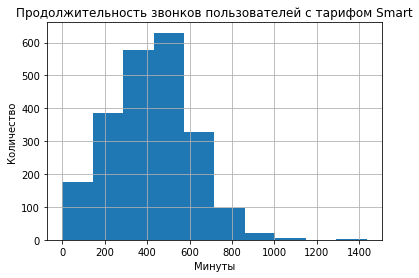

In [56]:
# Гистограмма по длительности звонков пользователей тарифа smart
smart_calls['sum_calls'].hist()
plt.title('Продолжительность звонков пользователей с тарифом Smart')
plt.xlabel("Минуты")
plt.ylabel("Количество")

#### Ультра

In [57]:
# Услуги для пользователей тарифа ultra
ultra_calls=new_data.query('tariff=="ultra"')
ultra_calls.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,...,3.0,1000,30720,3000,1950,150,1,1,30,1950.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,...,23.0,1000,30720,3000,1950,150,1,1,30,1950.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0


In [58]:
# Среднее по длительности звонков пользователей тарифа ultra
c2_mean=ultra_calls['sum_calls'].mean().astype(int)
c2_mean

548

In [59]:
# Дисперсия по выборке длительности звонков пользователей тарифа ultra
disp1=np.var(ultra_calls['sum_calls'], ddof=1).round(2)
disp1

94015.43

In [60]:
# Стандартное отклонение по длительности звонков пользователей тарифа ultra
o_c2=np.sqrt(disp1).round(2)
o_c2

306.62

In [61]:
#Распределение
distr2 = st.norm(c2_mean, o_c2) 
x = c2_mean
distr2.cdf(x) 

0.5

Text(0, 0.5, 'Количество')

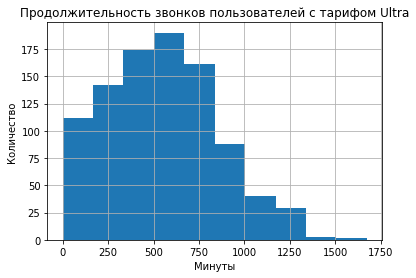

In [62]:
# Гистограмма по длительности звонков пользователей тарифа ultra
ultra_calls['sum_calls'].hist()
plt.title('Продолжительность звонков пользователей с тарифом Ultra')
plt.xlabel("Минуты")
plt.ylabel("Количество")

#### Сравнение тарифов

In [63]:
#Сравнение длительности звонков клиентов с разными тарифными планами
comparison_tariffs_calls=new_data.pivot_table(index =['tariff'], aggfunc = {'sum_calls':'mean'}).reset_index()
comparison_tariffs_calls['sum_calls']=comparison_tariffs_calls['sum_calls'].astype(int)
comparison_tariffs_calls.head()

,tariff,sum_calls
0,smart,419
1,ultra,548


Text(0, 0.5, 'Звонки')

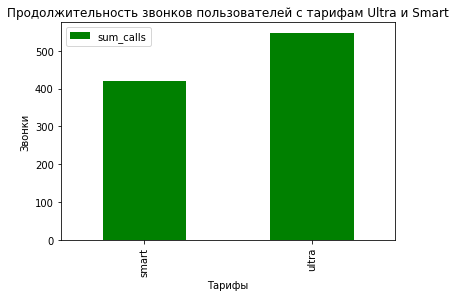

In [64]:
# Визуализация сравнения тарифов
comparison_tariffs_calls.plot.bar(x='tariff', y='sum_calls', color='green')
plt.title('Продолжительность звонков пользователей с тарифам Ultra и Smart')
plt.xlabel("Тарифы")
plt.ylabel("Звонки")

### Потребность клиентов в ежемесячном количестве сообщений

Для подстчёта значений буду использовать созданные таблицы `smart_calls` и `ultra_calls`

#### Смарт

In [65]:
smart_calls.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
8,8,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
9,9,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12.0,...,14.0,50,15360,500,550,200,3,3,15,550.0
10,10,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6.0,...,11.0,50,15360,500,550,200,3,3,15,550.0
11,11,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
12,12,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,8.0,...,20.0,50,15360,500,550,200,3,3,15,1550.0


In [66]:
# Среднее количество сообщений у пользователей тарифа smart
m1_mean=smart_calls['mess'].mean().astype(int)
m1_mean

38

In [67]:
# Дисперсия по выборке количества сообщений пользователей тарифа smart
disp3=np.var(smart_calls['mess'], ddof=1).round(2)
disp3

718.8

In [68]:
# Стандартное отклонение по количеству сообщений пользователей тарифа smart
o_m1=np.sqrt(disp3).round(2)
o_m1

26.81

In [69]:
#Распределение
distr3 = st.norm(m1_mean, o_m1) 
x = m1_mean
distr3.cdf(x) 

0.5

Text(0.5, 0, 'количество сообщений')

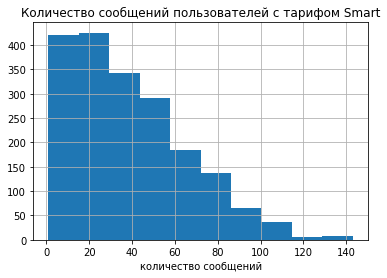

In [70]:
# Гистограмма по количеству сообщений пользователей тарифа smart
smart_calls['mess'].hist()
plt.title('Количество сообщений пользователей с тарифом Smart')
plt.xlabel("количество сообщений")

#### Ультра

In [71]:
ultra_calls.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,...,3.0,1000,30720,3000,1950,150,1,1,30,1950.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,...,23.0,1000,30720,3000,1950,150,1,1,30,1950.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0


In [72]:
# Среднее количество сообщений у пользователей тарифа ultra
m2_mean=ultra_calls['mess'].mean().astype(int)
m2_mean

61

In [73]:
# Дисперсия по выборке количества сообщений пользователей тарифа ultra
disp4=np.var(ultra_calls['mess'], ddof=1).round(2)
disp4

2008.55

In [74]:
# Стандартное отклонение по количеству сообщений пользователей тарифа ultra
o_m2=np.sqrt(disp4).round(2)
o_m2

44.82

In [75]:
#Распределение
distr4 = st.norm(m2_mean,o_m2) 
x = m2_mean
distr4.cdf(x) 

0.5

Text(0.5, 0, 'количество сообщений')

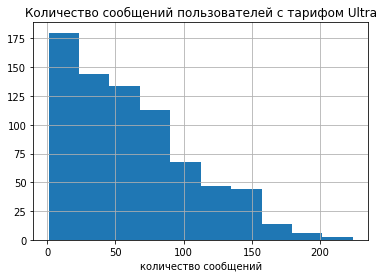

In [76]:
# Гистограмма по количеству сообщений пользователей тарифа ultra
ultra_calls['mess'].hist()
plt.title('Количество сообщений пользователей с тарифом Ultra')
plt.xlabel("количество сообщений")

#### Сравнение тарифов

In [77]:
#Сравнение потребности в сообщениях клиентов с разными тарифными планами
comparison_tariffs_messages=new_data.pivot_table(index =['tariff'], aggfunc = {'mess':'mean'}).reset_index()
comparison_tariffs_messages['mess']=comparison_tariffs_messages['mess'].astype(int)
comparison_tariffs_messages.head()

,tariff,mess
0,smart,38
1,ultra,61


Text(0, 0.5, 'Сообщения')

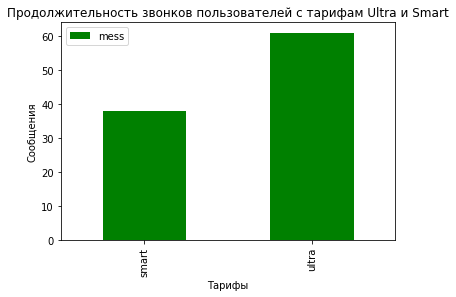

In [78]:
# Визуализация сравнения тарифов
comparison_tariffs_messages.plot.bar(x='tariff', y='mess', color='green')
plt.title('Продолжительность звонков пользователей с тарифам Ultra и Smart')
plt.xlabel("Тарифы")
plt.ylabel("Сообщения")

### Потребности клиентов в объёме интернет-трафика

#### Смарт

In [79]:
#Сначала рассматриваю и считаю данные для тарифа Smart
smart_calls.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
8,8,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
9,9,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12.0,...,14.0,50,15360,500,550,200,3,3,15,550.0
10,10,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6.0,...,11.0,50,15360,500,550,200,3,3,15,550.0
11,11,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
12,12,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,8.0,...,20.0,50,15360,500,550,200,3,3,15,1550.0


In [80]:
# Средний объём интернет-трафика у пользователей тарифа smart
u1_mean=smart_calls['used_gb'].mean().astype(int)
u1_mean

16

In [81]:
# Дисперсия по выборке объёма интернет-трафика пользователей тарифа smart
disp5=np.var(smart_calls['used_gb'], ddof=1).round(2)
disp5

32.99

In [82]:
# Стандартное отклонение по объёму интернет-трафика пользователей тарифа smart
o_u1=np.sqrt(disp5).round(2)
o_u1

5.74

In [83]:
#Распределение
distr5 = st.norm(u1_mean, o_u1) 
x = u1_mean
distr5.cdf(x) 

0.5

Text(0.5, 0, 'количество гигабайт')

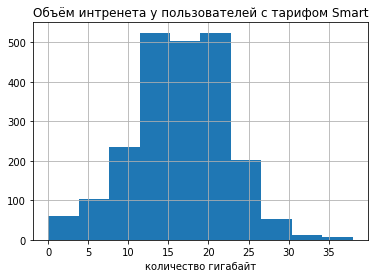

In [84]:
# Гистограмма по объёму интренет-трафика пользователей тарифа smart
smart_calls['used_gb'].hist()
plt.title('Объём интренета у пользователей с тарифом Smart')
plt.xlabel("количество гигабайт")

#### Ультра

In [85]:
#Данные для тарифа Ultra
ultra_calls.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,...,3.0,1000,30720,3000,1950,150,1,1,30,1950.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,...,23.0,1000,30720,3000,1950,150,1,1,30,1950.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0


In [86]:
# Средний объём интернет-трафика у пользователей тарифа ultra
u2_mean=ultra_calls['used_gb'].mean().astype(int)
u2_mean

19

In [87]:
# Дисперсия по выборке объёма интернет-трафика пользователей тарифа Ultra
disp6=np.var(ultra_calls['used_gb'], ddof=1).round(2)
disp6

94.78

In [88]:
# Стандартное отклонение по объёму интернет-трафика пользователей тарифа Ultra
o_u2=np.sqrt(disp6).round(2)
o_u2

9.74

In [89]:
#Распределение
distr6 = st.norm(u2_mean, o_u2) 
x = u2_mean
distr6.cdf(x) 

0.5

Text(0.5, 0, 'количество гигабайт')

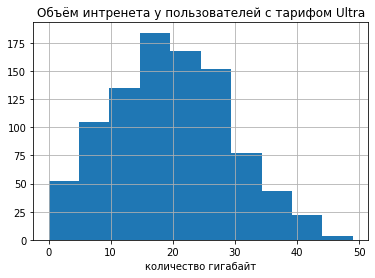

In [90]:
# Гистограмма по объёму интренет-трафика пользователей тарифа Ultra
ultra_calls['used_gb'].hist()
plt.title('Объём интренета у пользователей с тарифом Ultra')
plt.xlabel("количество гигабайт")

#### Сравнение тарифов

In [91]:
#Сравнение потребности в сообщениях клиентов с разными тарифными планами
comparison_tariffs_internet=new_data.pivot_table(index =['tariff'], aggfunc = {'used_gb':'mean'}).reset_index()
comparison_tariffs_internet['used_gb']=comparison_tariffs_internet['used_gb'].astype(int)
comparison_tariffs_internet.head()

,tariff,used_gb
0,smart,16
1,ultra,19


Text(0, 0.5, 'Звонки')

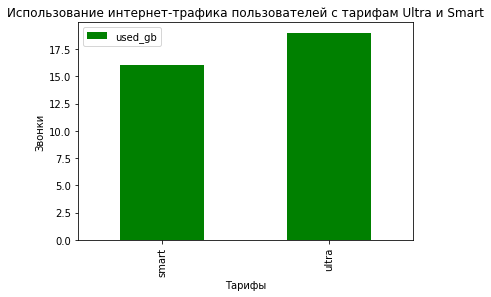

In [92]:
# Визуализация сравнения тарифов
comparison_tariffs_internet.plot.bar(x='tariff', y='used_gb', color='green')
plt.title('Использование интернет-трафика пользователей с тарифам Ultra и Smart')
plt.xlabel("Тарифы")
plt.ylabel("Звонки")

*Для наглядности, визуализирую данные по всем требуемым услугам в каждои тарифном плане*

Text(0.5, 0.98, 'Оценка потребности в услугах клиентов с тарифом Smart')

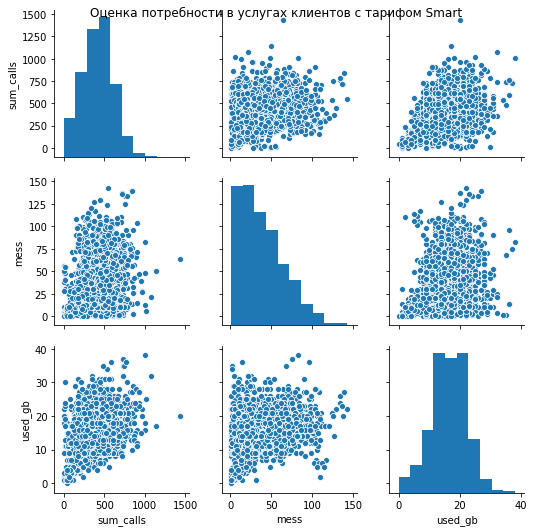

In [93]:
#Тарифный план Smart
sb_plot = sb.pairplot(smart_calls[['sum_calls', 'mess', 'used_gb']])
sb_plot.savefig('pairplot.png')

plt.suptitle('Оценка потребности в услугах клиентов с тарифом Smart')

Text(0.5, 0.98, 'Оценка потребности в услугах клиентов с тарифом Ultra')

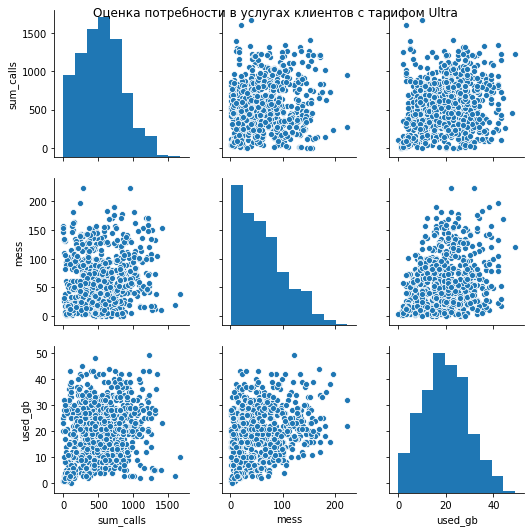

In [94]:
# Тарифный план Ultra
sb_plot = sb.pairplot(ultra_calls[['sum_calls', 'mess', 'used_gb']])
sb_plot.savefig('pairplot.png')

plt.suptitle('Оценка потребности в услугах клиентов с тарифом Ultra')

### Выводы

Проанализировав данные выборки могу сказать следующие:
- Потребности в услугах абонентов разных отличаются и в некоторых случаях не соответсвуют пакетным предложениям. Средняя продолжительность звонка в рамках Smart - 419 минут в месяц, а Ultra 548 при пакетных 500 и 3000 соответсвенно. Пользователи сообщений отправляют в рамках тарифных планов. 38 и 61 для Smart и Ultra, соответственно. А объём интернета, необходимого клиентам распределёе иначе: клиенты со Smart тарифпм расходуют в среднем 16 Гб в месяц (в пакете 15), в клиенты с Ultra - 19Гб (в пакете 30).
- Визуально и согласно формуле, все проанализированные данные выборки распределены нормально. Это может свидетельствовать о нормальном распределении генеральной совокупности.

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

*Чтобы проверить данну. гипотезу, надо определить среднее необходимого значению по каждому тарифу отдельно. И после этого сравнить среднее пбеих выборок.*
У нас уже есть две таблицы с данными по услугам клиентов с тарифами `Smart`  `Ultra`. Посчитаю по каждой среднее.

In [95]:
# Данные по тарифу Smart
smart_calls.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
8,8,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
9,9,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12.0,...,14.0,50,15360,500,550,200,3,3,15,550.0
10,10,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6.0,...,11.0,50,15360,500,550,200,3,3,15,550.0
11,11,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
12,12,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,8.0,...,20.0,50,15360,500,550,200,3,3,15,1550.0


In [96]:
# Данные по тарифу Ultra
ultra_calls.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,...,3.0,1000,30720,3000,1950,150,1,1,30,1950.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,...,23.0,1000,30720,3000,1950,150,1,1,30,1950.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0


#### Анализ выборки

In [97]:
#Среднее значение выручки дл пользователей с тарифом Smart
r1_mean=smart_calls['revenue'].mean().astype(int)
r1_mean

1291

In [98]:
#Среднее значение выручки дл пользователей с тарифом Ultra
r2_mean=ultra_calls['revenue'].mean().astype(int)
r2_mean

2072

In [99]:
# Информаци о таблице, в т.ч. о количестве строк и размере
smart_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2222 entries, 8 to 3173
Data columns (total 27 columns):
index_x                  2222 non-null int64
user_id                  2222 non-null int64
age_x                    2222 non-null int64
churn_date               111 non-null object
city                     2222 non-null object
first_name               2222 non-null object
last_name                2222 non-null object
reg_date                 2222 non-null object
tariff                   2222 non-null object
month                    2222 non-null float64
count_calls              2222 non-null float64
sum_calls                2222 non-null float64
mess                     1915 non-null float64
Unnamed: 0               2222 non-null float64
age_y                    2222 non-null float64
index_y                  2222 non-null float64
mb_used                  2222 non-null float64
used_gb                  2222 non-null float64
messages_included        2222 non-null int64
mb_per_month_in

In [100]:
# Информаци о таблице, в т.ч. о количестве строк и размере
ultra_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941 entries, 0 to 3150
Data columns (total 27 columns):
index_x                  941 non-null int64
user_id                  941 non-null int64
age_x                    941 non-null int64
churn_date               75 non-null object
city                     941 non-null object
first_name               941 non-null object
last_name                941 non-null object
reg_date                 941 non-null object
tariff                   941 non-null object
month                    941 non-null float64
count_calls              941 non-null float64
sum_calls                941 non-null float64
mess                     752 non-null float64
Unnamed: 0               941 non-null float64
age_y                    941 non-null float64
index_y                  941 non-null float64
mb_used                  941 non-null float64
used_gb                  941 non-null float64
messages_included        941 non-null int64
mb_per_month_included    941 non-nu

*Средние значения выборок, как и размер датасентов отличаются. Далее, проверю распределение чтобы окончательно определиться с методом сравнения гипотез.*

In [101]:
# Стандартное отклонение по выручке от пользователей тарифа Smart
o_r1=np.sqrt(r1_mean).round(2)
o_r1

35.93

In [102]:
# Распределение по значению выручки для Smart
distr7 = st.norm(r1_mean,o_r1) 

x = r1_mean

distr7.cdf(x)

0.5

In [103]:
# Стандартное отклонение по выручке от пользователей тарифа Ultra
o_r2=np.sqrt(r2_mean).round(2)
o_r2

45.52

In [104]:
# Распределение по значению выручки для Ultra
distr8 = st.norm(r2_mean,o_r2) 

x = r2_mean

distr8.cdf(x)

0.5

*Несмотря на то, что распределение нормальное у каждой выборки, они отличаются средним и размером. Для сравнения датасентов использую метод `scipy.stats.ttest_ind ()` без применения t-теста.*

#### Формирование и сравнение гипотез

**Нулевоя гипотеза гласит: `средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается`. Я сформулирую альтернативную для выборок и сравнения: `средняя выручка пользователей тарифов «Ультра» и «Смарт» различается`.**<br>
Если значение p-value будет, боьше критического уровня статистической значимости, то отвергнуть нулевую гипотезу не получится, если меньше - отвергнуть альтернативную гипотезу не получится.

In [105]:
alpha=0.01 #критический уровень статистической значимости

result = st.ttest_ind (ultra_calls['revenue'],smart_calls['revenue'], equal_var = False) #equal_var = False потому что выборки не равны и имеют разное среднее

display(result.pvalue)

if result.pvalue > alpha:
    display('Отвергнуть нулевую гипотезу не получится')
else:
    display('Отвергнуть альтернативную гипотезу не получится')

4.722558075302507e-244

'Отвергнуть альтернативную гипотезу не получится'

#### Промежуточный вывод

Проанализировав различные критерии выручки с клиентов разных тарифов, я сравнила выбоки. Для этого была сформулирована нулевая гипотеза: `средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается` и альтернативная `средняя выручка пользователей тарифов «Ультра» и «Смарт» различается`.<br>
Сравнение средних разных выборок дало возможность утверждать, что альтернативную гипотезу отклонить не удасться, а значит, `средняя выручка пользователей тарифов «Ультра» и «Смарт» различается`.<br>
Критический уроветь статистической значимости выбран таким образом, чтобы оценить минимальные отличия.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Чтобы оценить выручку от москвижей и жителей других регионов, создам таблицы, соответсвующие требованиям. Применю `query`.

In [106]:
# Для срезов берём общую таблицу с выручкой
new_data.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,...,3.0,1000,30720,3000,1950,150,1,1,30,1950.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,...,23.0,1000,30720,3000,1950,150,1,1,30,1950.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0


In [107]:
# Таблица выручки по клиентам из Москвы
moscow_revenue=new_data.query('city=="Москва"')
moscow_revenue.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
8,8,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11.0,...,18.0,50,15360,500,550,200,3,3,15,1150.0
9,9,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12.0,...,14.0,50,15360,500,550,200,3,3,15,550.0
17,17,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8.0,...,9.0,1000,30720,3000,1950,150,1,1,30,1950.0
18,18,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,9.0,...,13.0,1000,30720,3000,1950,150,1,1,30,1950.0
19,19,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,10.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0


In [108]:
# Таблица выручки по клиентам не из Москвы
all_regions_revenue=new_data.query('city!="Москва"')
all_regions_revenue.head()

,index_x,user_id,age_x,churn_date,city,first_name,last_name,reg_date,tariff,month,...,used_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,...,3.0,1000,30720,3000,1950,150,1,1,30,1950.0
1,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,...,23.0,1000,30720,3000,1950,150,1,1,30,1950.0
2,2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
3,3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,...,14.0,1000,30720,3000,1950,150,1,1,30,1950.0
4,4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,...,15.0,1000,30720,3000,1950,150,1,1,30,1950.0


#### Анализ выборки

In [109]:
# Средняя выручка по Москве
m_mean=moscow_revenue['revenue'].mean().astype(int)
m_mean

1546

In [110]:
# Средняя выручка по регионам исключая Моску
all_mean=all_regions_revenue['revenue'].mean().astype(int)
all_mean

1518

*Чтобы сравнить средную выручку разных выручек, сформировать альтернативную гипотезу и сравнить гипотезы, надо определить  распределение и узнать размер выборок*

In [111]:
moscow_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 8 to 3122
Data columns (total 27 columns):
index_x                  610 non-null int64
user_id                  610 non-null int64
age_x                    610 non-null int64
churn_date               41 non-null object
city                     610 non-null object
first_name               610 non-null object
last_name                610 non-null object
reg_date                 610 non-null object
tariff                   610 non-null object
month                    610 non-null float64
count_calls              610 non-null float64
sum_calls                610 non-null float64
mess                     491 non-null float64
Unnamed: 0               610 non-null float64
age_y                    610 non-null float64
index_y                  610 non-null float64
mb_used                  610 non-null float64
used_gb                  610 non-null float64
messages_included        610 non-null int64
mb_per_month_included    610 non-nu

In [112]:
all_regions_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2553 entries, 0 to 3173
Data columns (total 27 columns):
index_x                  2553 non-null int64
user_id                  2553 non-null int64
age_x                    2553 non-null int64
churn_date               145 non-null object
city                     2553 non-null object
first_name               2553 non-null object
last_name                2553 non-null object
reg_date                 2553 non-null object
tariff                   2553 non-null object
month                    2553 non-null float64
count_calls              2553 non-null float64
sum_calls                2553 non-null float64
mess                     2176 non-null float64
Unnamed: 0               2553 non-null float64
age_y                    2553 non-null float64
index_y                  2553 non-null float64
mb_used                  2553 non-null float64
used_gb                  2553 non-null float64
messages_included        2553 non-null int64
mb_per_month_in

In [113]:
# Стандартное отклонение по выручке для Москвы
o_m=np.sqrt(m_mean).round(2)
o_m

39.32

In [114]:
# Распределение по значению выручки для Москвы
distr9 = st.norm(m_mean,o_m) 

x = m_mean

distr9.cdf(x)

0.5

In [115]:
# Стандартное отклонение по выручке не для Москвы
o_all=np.sqrt(all_mean).round(2)
o_all

38.96

In [116]:
# Распределение по значению выручки не для Москвы
distr0 = st.norm(all_mean,o_all) 

x = all_mean

distr0.cdf(x)

0.5

*Несмотря на то, что распределение в выборке нормальное, её размер и среднее значение по выручке отличаются. Для сравнения датасентов использую метод `scipy.stats.ttest_ind ()` без применения t-теста.*

#### Формирование и сравнение гипотиз

**Нулевоя гипотеза гласит: `средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов`. Я сформулирую альтернативную для выборок и сравнения: `средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов`.**<br>
Если значение p-value будет больше критического уровня статистической значимости, то Отвергнуть нулевую гипотезу не получится, если меньше -Отвергнуть альтернативную гипотезу не получится.

In [117]:
alpha=0.01 #критический уровень статистической значимости

result = st.ttest_ind (moscow_revenue['revenue'], all_regions_revenue['revenue'], equal_var = False) #equal_var = False потому что выборки не равны и имеют разное среднее

display(result.pvalue)

if result.pvalue > alpha:
    display('Отвергнуть нулевую гипотезу не получится')
else:
    display('Отвергнуть альтернативную гипотезу не получится')

0.4193289449516847

'Отвергнуть нулевую гипотезу не получится'

#### Промежуточный вывод

Проанализировав различные критерии выручки с клиентов разных Москвы и других регионов, я сравнила выбоки. Для этого была сформулирована нулевая гипотеза: `средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов` и альтернативная `средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов`.<br>
Сравнение средних разных выборок дало возможность утверждать, что нулевую гипотезу отклонить не удасться, а значит, `средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов`.<br>
Критический уроветь статистической значимости выбран таким образом, чтобы оценить минимальные отличия.

### Вывод

Проанализировав данные, могу сказать следующее:
- В выборках, а значит и в генеральной совокупности, значения распределены нормально.
- Первую альтернативную гипотезу после сравнения двух средних без применения t-теста отвергнуть не удалось, а значит выручка от пользователей разных тарифных планом отличается.
- К каждой нулевой гипотезе была сформулирована альтернативная. Если в первом случае альтернативная гипотеза не блы отвергнута, то во втором, после сравнения средних по выруке в разных регионах, нулевую гипотизу не удалось отвергнуть. Это значит, что выручка от пользователей в Москве не отличается, от той, которую приносят клиенты из других регионов. 

## Общий вывод

1. Для работы было представлены выборки с различными данными мобильного оператора `"Мегалайн"` (данные пользователей, сведения о звонках, сообщениях, интренет-трафике и тарифах). Все таблицы были проверены на наличие ошибок: пропусков, дубликатов, неверного типа данных. Ошибок как таковых не выявила, но для удобства изменила название столбцов, а также округлила данные согласно правилам мобильного оператора, который секунду разговора округляет до минуты, а мегадайты до гигабайт.  Применены матоды: `info(), isna(), duplicated(), np.ceil, rename()`.
2. Для проведения предварительных подсчётов объединила с помощью `merge()` несколько таблиц: сведения о пользователях и звонках, сведения о пользователях и сообщениях, сведения о пользователях и интернет-трафике. После объединения удалила строки снемногочисленными пропусками, которые могли повлиять на результат анализа данных. Для этого применила метод `dropna()`. В каждую полученную таблицу добавила колонку с номером месяца (`to_datetime()` ), после чего создала сводные таблицы (`pivot_table`) по интересующим меня признакам: количество звонков и сумма использованных минут для каждого клиента по месяцам, количество отправленных сообщений от каждого пользователя в месяц, объём интрнет-трафика клинетов по месяцам. <br>
Для расчёта выручки в первую очередь, я объединила сводные таблицы (`merge()`) с данными об услугах для каждого пользователя помесячно. Далее, удалила мешающие пропуски ( `dropna()`) . Используя имеющиеся сведения о тарифных планах, применила  ко всей таблице функцию `revenue`, которая дла тарифов `smart` и `ultra` рассчитала выручку (вычла бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножила на значение из тарифного плана и прибавила абонентскую плату). В случаях, где услуг получено больше, чем предусмотрено тарифным планом, компания с каждого клиента получает стоимость абонентской платы и оплату услег вне пакета, по заявленным тарифам.
3. Для работы создала таблицы по срезам (`query()`) для каждого траифного плана. Анализирую данные для разговоров, сообщений и интрнет-трафика по каждому тарифу, я рассчитывала среднее, дисерсию, стандартное отклонение и распределение значений нужных признаков, Для визуализации каждого параметра построена гистограмма. Использованы методы: `mean(),np.var(),   
4. Прежде чем проверять заявленные гипотезы, я проверила среднее, отклонение и распределение по требуемым значениям, Только после этого проверяла равество средних. Первую нулевую гипотезу `"средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются"` подтвердить н еудалось, поскольку альтернативную гипотезу `"средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"` не удалось отклонить. Для работы над второй гипотизой я создала таблицы с данными по Москве и другим регионам (`query()`). Изначальную нулевую гипотезу `средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов` отклонить не удалось.<br>
Отмечу, что изначально при работе с таблицами в них были оставлены сведения о регионах, для того чтобы применить их в работе с гипотизами.
5. Отдельно хочу отметить, что остаются сомнения в отношении первой гипотизы из-за сомнительной (по моему мнению) размеру p-значения.
6. Предположу, что на проверку гипотезы мог повлиять характер выборки, работа функции, удаление пропусков и другие факторы.